In [1]:
import iamend_ci as ci
import numpy as np

Loading BokehJS ...

In [2]:
exp=ci.exp('./iamend_ci/datos/marzo2023/m1')

                  archivo  conductividad  espesor bobina  muestras
0      Exp_m1_347-M02.csv     1118491.27  0.02340     m1   347-M02
1  Exp_m1_1010-M01_m1.csv     3830000.00  0.06500     m1  1010-M01
2         Exp_m1_aire.csv           0.00  0.00000     m1      aire
3         Exp_m1_P057.csv     3948000.00  0.14957     m1      P057


In [4]:
exp.fitpatron(plot=True)

z1 = 0.969217875046711 mm


True

In [3]:
exp.fitmues()
exp.info

Ajustando z1 effectivo
z1 = 0.969217875046711 mm


IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
exp2=ci.exp('./iamend_ci/datos/marzo2023/pp1')


                archivo  conductividad  espesor bobina  muestras
0  Exp_pp1_1010-M01.csv     3830000.00  0.06500    pp1  1010-M01
1      Exp_pp1_aire.csv           0.00  0.00000    pp1      aire
2   Exp_pp1_347-M02.csv     1118491.27  0.02340    pp1   347-M02
3      Exp_pp1_P057.csv     3948000.00  0.14957    pp1      P057


In [7]:
exp2.fitpatron(plot=True)

z1 = 1.4802302940887324 mm


True

In [ ]:
exp2.fitmues()
exp2.info

# Intervalo de confianza para parametros de un ajuste no lineal

En orden de poder comparar ambas mediciones y tener un metodo robusto para la caracterizacion de la permeabilidad, necesitamos definir un intervalo de confianza para el parametro $\mu$

La estimacion de $\mu$ se realiza con la funcion `optimize.curve_fit` de la libreria `scipy` una implementacion de  non-linear least squares para ajustar una funcion $f$ (modelo analitico) a los datos de impedancia normalizados.  el algorithm uses the Levenberg-Marquardt algorithm through leastsq.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares


Segun la libreria podemos definir el error en $\mu$ como `np.sqrt(np.diag(pcov))`.

```
pcov2-D array
The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).

How the sigma parameter affects the estimated covariance depends on absolute_sigma argument, as described above.

If the Jacobian matrix at the solution doesn’t have a full rank, then ‘lm’ method returns a matrix filled with np.inf, on the other hand ‘trf’ and ‘dogbox’ methods use Moore-Penrose pseudoinverse to compute the covariance matrix.

```

In [5]:
from iamend_ci.fit import mu as fitmu

In [6]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.084565,0.983903
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.333505,0.983925
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [7]:
f=exp.f
bo_eff=exp.coil
dpatron=exp.info.espesor[0]
sigma=exp.info.conductividad[0]
name=exp.info.muestras[0]

In [43]:
name

'347-M02'

In [44]:
dzucorrnorm=exp.dznorm[exp.dznorm.muestra==name].dzcorrnorm.values

In [45]:
fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)

In [46]:
fpar

array([43.08456502])

In [10]:
exp2.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_pp1_1010-M01.csv,3830000.00,0.06500,pp1,1010-M01,71.253101,0.983451
1,Exp_pp1_aire.csv,0.00,0.00000,pp1,aire,NaN,NaN
2,Exp_pp1_347-M02.csv,1118491.27,0.02340,pp1,347-M02,47.056389,0.976415
3,Exp_pp1_P057.csv,3948000.00,0.14957,pp1,P057,NaN,NaN


In [55]:
i=2
f2=exp2.f
bo_eff2=exp2.coil
dpatron2=exp2.info.espesor[i]
sigma2=exp2.info.conductividad[i]
name2=exp2.info.muestras[i]
dzucorrnorm2=exp2.dznorm[exp2.dznorm.muestra==name2].dzcorrnorm.values
fpar2, pcov2=fitmu(f2,bo_eff2,dzucorrnorm2,dpatron2,sigma2,name2)

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_ci(fpar,pcov,fpar2,pcov2):
    plt.figure(figsize=[8,2])
    x11=fpar[0]-np.sqrt(pcov[0][0])
    x12=fpar[0]+np.sqrt(pcov[0][0])
    y1=1
    x21=fpar2[0]-np.sqrt(pcov2[0][0])
    x22=fpar2[0]+np.sqrt(pcov2[0][0])
    y2=1
    plt.plot([x11,x12],[y1,y1], linewidth=15, alpha=0.5, label='_nolegend_')
    plt.plot([x21,x22],[y2,y2], linewidth=15, alpha=0.5, label='_nolegend_')
    plt.plot(fpar[0],y1, 'ok')
    plt.plot(fpar2[0],y2, 'vk')
    plt.ylim([0,2])
    plt.legend([str(fpar[0].round(2)),str(fpar2[0].round(2))])
    #get current axes
    ax = plt.gca()

    #hide y-axis
    ax.get_yaxis().set_visible(False)

    

In [61]:
def compare(exp1,exp2,muestra):
    f=exp1.f
    j=exp1.info[exp1.info.muestras == muestra].index.values[0]
    bo_eff=exp1.coil
    dpatron=exp1.info.espesor[j]
    sigma=exp1.info.conductividad[j]
    name=exp1.info.muestras[j]
    dzucorrnorm=exp1.dznorm[exp1.dznorm.muestra==name].dzcorrnorm.values
    f2=exp2.f
    bo_eff2=exp2.coil
    i=exp2.info[exp2.info.muestras == muestra].index.values[0]
    dpatron2=exp2.info.espesor[i]
    sigma2=exp2.info.conductividad[i]
    name2=exp2.info.muestras[i]
    dzucorrnorm2=exp2.dznorm[exp2.dznorm.muestra==name2].dzcorrnorm.values
    fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)
    fpar2, pcov2=fitmu(f2,bo_eff2,dzucorrnorm2,dpatron2,sigma2,name2)
    plot_ci(fpar,pcov,fpar2,pcov2)

In [17]:
# se solapan!

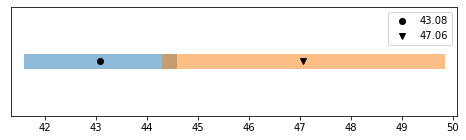

In [59]:
muestra='347-M02'
compare(exp,exp2,muestra)

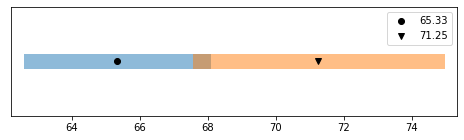

In [60]:
muestra='1010-M01'
compare(exp,exp2,muestra)1234


### Bootstrap resampling


- Let $X$ denote your training dataset. Let $n$ denote the number of samples in your training data. Let $k$ denote the number of resampling iterations you want to perform. The more the better, but k should probably be no fewer than 1000.

- for $i=1,2,…k$ take a random sample $X_i$ (with replacement) of size $n$ from $X$. Train your model and calculate your model paramters. Let $\mu_i$ denote your fitted parameters trained on the ith resampled data set.

- You can now calculate confidence intervals by determining the quantiles of $\hat{\mu} =[ \mu_0,\mu_1,\mu_2,...\mu_k]$ 

For example, to obtain a 95% confidence interval, calculate the 2.5% and 97.5% quantiles of $\hat{\mu}$.

    [1]Reference: Chapters seven and eight of 'The Elements of Statistical Learning'
    
La funcion es:    
    
```
    mu(f,bo_eff,dzucorrnorm,dpatron,sigma, name)
```

Podemos ajustar mu bootstrapeando dzcorrnorm

In [20]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.084565,0.983903
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.333505,0.983925
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [21]:
exp.dznorm

,f,muestra,dzcorrnorm,imag,real
0,100.0000,347-M02,-0.103694+0.104691j,0.104691,-0.103694
1,125.8925,347-M02,-0.081795+0.106285j,0.106285,-0.081795
2,158.4893,347-M02,-0.064692+0.109922j,0.109922,-0.064692
3,199.5262,347-M02,-0.051708+0.107111j,0.107111,-0.051708
4,251.1886,347-M02,-0.040501+0.105857j,0.105857,-0.040501
...,...,...,...,...,...
118,398107.2000,P057,0.019866-0.093461j,-0.093461,0.019866
119,501187.3000,P057,0.018207-0.095853j,-0.095853,0.018207
120,630957.3000,P057,0.017107-0.098689j,-0.098689,0.017107
121,794328.3000,P057,0.016394-0.101772j,-0.101772,0.016394


In [35]:
# quiero corregir y normalizar repeticiones individualmente

In [22]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.084565,0.983903
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.333505,0.983925
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [23]:
muestra='1010-M01'
indice_muestra=1
zus=[]
for r in range(1,12):
    repeticion=r
 
    df_muestra=exp.data[indice_muestra]
    df_repeticion=df_muestra[df_muestra.repeticion == repeticion]
    zu=df_repeticion.real.values + 1j*df_repeticion.imag.values
    zus.append(zu)


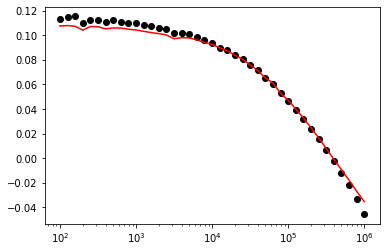

In [24]:
import matplotlib.pyplot as plt

plt.semilogx(exp.f,(np.array(zus).mean(axis=0).imag-exp.za.imag)/exp.za.imag,'ok')
plt.semilogx(exp.f,exp.dznorm[exp.dznorm.muestra==muestra].imag,'-r')

In [25]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.084565,0.983903
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.333505,0.983925
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [32]:
i=0
muestra='347-M02'
mues1=[]
for r in range(1,12):
    repeticion=r
    f=exp.f
    bo_eff=exp.coil
    dpatron=exp.info.espesor[i]
    sigma=exp.info.conductividad[i]
    name=exp.info.muestras[i]
    dzucorrnorm=ci.so.corrnorm(exp,muestra,repeticion)
    fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)
    mues1.append(fpar)
    print(r,fpar[0],np.round(100*np.sqrt(pcov)[0][0]/fpar[0]),'%')

1 43.72615507829536 3.0 %
2 42.87473105025235 3.0 %
3 43.09246990512072 4.0 %
4 42.03177294677831 4.0 %
5 42.72577592774194 3.0 %
6 42.41989686759756 3.0 %
7 43.59277406987629 4.0 %
8 42.240819143731635 5.0 %
9 43.938075850949375 4.0 %
10 43.26406858277084 4.0 %
11 44.79350107169607 3.0 %


In [29]:
exp2.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_pp1_1010-M01.csv,3830000.00,0.06500,pp1,1010-M01,71.253101,0.983451
1,Exp_pp1_aire.csv,0.00,0.00000,pp1,aire,NaN,NaN
2,Exp_pp1_347-M02.csv,1118491.27,0.02340,pp1,347-M02,47.056389,0.976415
3,Exp_pp1_P057.csv,3948000.00,0.14957,pp1,P057,NaN,NaN


In [31]:
i=2
muestra='347-M02'
mues2=[]
for r in range(1,12):
    repeticion=r
    f=exp2.f
    bo_eff=exp2.coil
    dpatron=exp2.info.espesor[i]
    sigma=exp2.info.conductividad[i]
    name=exp2.info.muestras[i]
    dzucorrnorm=ci.so.corrnorm(exp2,muestra,repeticion)
    fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)
    mues2.append(fpar)
    print(r,fpar[0],np.round(100*np.sqrt(pcov)[0][0]/fpar[0]),'%')

1 46.02816296732667 6.0 %
2 46.39199301502737 5.0 %
3 47.50554634029756 6.0 %
4 48.025232737558284 6.0 %
5 47.169937601554466 6.0 %
6 48.23793940756696 6.0 %
7 46.74375823924665 6.0 %
8 46.27833856394814 6.0 %
9 48.11828712403737 6.0 %
10 46.15254344912544 6.0 %
11 46.48660202526401 6.0 %


In [33]:
mu2=np.array(mues2)

In [34]:
mu1=np.array(mues1)

In [35]:
mu1.mean()

43.15454913589186

In [36]:
mu2.mean()

47.012576497359355

In [37]:
mu2.std()

0.7976803381393354

In [39]:
mu1.std()

0.7823093899231489

In [41]:
def plot_ci2(fpar,pcov,fpar2,pcov2):
    plt.figure(figsize=[8,2])
    x11=fpar-np.sqrt(pcov)
    x12=fpar+np.sqrt(pcov)
    y1=1
    x21=fpar2-np.sqrt(pcov2)
    x22=fpar2+np.sqrt(pcov2)
    y2=1
    plt.plot([x11,x12],[y1,y1], linewidth=15, alpha=0.5, label='_nolegend_')
    plt.plot([x21,x22],[y2,y2], linewidth=15, alpha=0.5, label='_nolegend_')
    plt.plot(fpar,y1, 'ok')
    plt.plot(fpar2,y2, 'vk')
    plt.ylim([0,2])
    plt.legend([str(fpar.round(2)),str(fpar2.round(2))])
    #get current axes
    ax = plt.gca()

    #hide y-axis
    ax.get_yaxis().set_visible(False)   

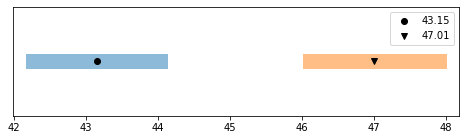

In [42]:
plot_ci2(mu1.mean(),mu1.std(),mu2.mean(),mu2.std())

In [141]:
def load(exp,separador=';'):
    folder_path=exp.path
    filepaths=exp.info.archivo.values

    #hay que remplazar por diccionario se mezclan los datos.
    data=list()
    for k,filepath in enumerate(filepaths):
        if ('info' not in filepath) & ('csv' in filepath):
            df=read(folder_path+'/'+filepath,separador)
            dfci=DataFrameCI(filename=filepath,bobina=exp.bobina,data=df)
            data.append(dfci) 
    return data  

In [143]:
data=load(exp)

In [145]:
data[0].filename

'Exp_m1_347-M02.csv'

In [147]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.252651,0.985932
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.639909,0.984095
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [94]:
def stats_dict(exp):
    ''' excluyendo la primer repeticion para cada muestra devuelve lista de valores medios por f y sus desvios'''
    data_mean={}
    data_std={}
    data_test={}

    for m,datamuestra_m in enumerate(exp.data):
        #excluimos la primer repeticion
        filename=datamuestra_m.filename
        name=exp.info[exp.info.archivo==filename].muestras.values[0]

        df=datamuestra_m[datamuestra_m.repeticion != 1 ]
        #separamos de manera aleatoria un valor de impedancia para cada frecuencia
        df_test=df.groupby('f').sample(1)

        #boramos del dataset original esos valores
        df.loc[df_test.index,'imag']=np.nan
        #calculamos mean y std 
        
        real_mean=df.groupby('f')['real'].mean().values
        imag_mean=df.groupby('f')['imag'].mean().values
        real_std=df.groupby('f')['real'].std().values
        imag_std=df.groupby('f')['imag'].std().values

        data_mean[name]=real_mean+1j*imag_mean
        data_std[name]=real_std+1j*imag_std
        data_test[name]=df_test

    return data_mean,data_std,data_test



def corrnorm(exp,muestra,repeticion):
    data_mean,data_std,data_test=stats_dict(exp)
    w=np.pi*2*exp.f
    z0=exp.bobina['R0']+1j*w*exp.bobina['L0']
    x0=w*exp.bobina['L0']  
    try:
        # correccion muestras
        za=data_mean['aire']
        indice_muestra=exp.info[exp.info.muestras == muestra].index.values[0]
        df_muestra=exp.data[indice_muestra]
        df_repeticion=df_muestra[df_muestra.repeticion == repeticion]
        zu_serie=df_repeticion.real + 1j*df_repeticion.imag
        zu=zu_serie.values
        dzucorr=((1/(1/zu - 1/za+ 1/z0))-z0  )				
        dzucorrnorm=dzucorr/x0
        return dzucorrnorm
    except Exception as e:
        print(e)

3
3
3
3
3
3
3
3
3
3


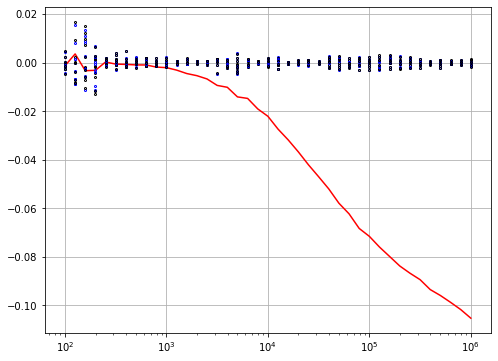

In [28]:
muestra='P057'
plt.figure(figsize=[8,6])
plt.semilogx(exp.f,exp.dznorm[exp.dznorm.muestra==muestra].imag,'-r')

for r in range(1,11):
    repeticion=r
    indice_muestra=exp.info[exp.info.muestras == muestra].index.values[0]
    print(indice_muestra)
    df_muestra=exp.data[indice_muestra]
    df_repeticion=df_muestra[df_muestra.repeticion == repeticion]
    zu=df_repeticion.real + 1j*df_repeticion.imag
    dzucorrnorm_repeticion=corrnorm(exp,muestra,repeticion)
    plt.semilogx(exp.f,dzucorrnorm_repeticion.imag,'ob',markersize=2,markerfacecolor='none')
    plt.semilogx(exp.f,(zu.values.imag-exp.za.imag)/exp.za.imag,'ok',markersize=2,markerfacecolor='none')
plt.grid(True)

In [29]:
corrnorm(exp,muestra,repeticion)

array([-5.59727851e-02-1.21580811e-03j, -4.84688042e-02+4.40977484e-04j,
       -3.43950274e-02-9.63122649e-03j, -3.21460406e-02+7.30586841e-03j,
       -2.25925072e-02-1.58441938e-03j, -1.28281301e-02+3.67391351e-04j,
       -1.53137758e-02-1.24509719e-03j, -1.05787503e-02+6.48031219e-04j,
       -1.22750199e-03+1.74033256e-03j, -8.50200794e-03-1.31200160e-03j,
       -4.89616784e-03-1.80782333e-03j, -5.47417235e-03-8.34964601e-04j,
       -3.18228537e-03-4.29080147e-04j, -2.51911627e-03-6.65145312e-04j,
       -1.50018300e-03+6.11442648e-04j, -6.51686791e-04+2.38809950e-04j,
       -2.60604379e-03+1.26536479e-03j, -2.16185674e-03-1.80872536e-03j,
       -1.23429430e-03-1.10934849e-03j, -8.16528033e-04+1.02076405e-04j,
       -7.24027181e-04+1.91666147e-03j, -1.54486432e-04-6.08356602e-04j,
       -1.45241630e-04+1.66064092e-04j,  7.05231976e-04-4.79991426e-04j,
       -5.05471443e-04-1.31847963e-04j,  1.49414742e-04+1.57288331e-04j,
        1.80336790e-04+2.85735595e-04j,  2.27090444

In [66]:
f2=exp2.f
bo_eff2=exp2.coil
i=2
dpatron2=exp2.info.espesor[i]
sigma2=exp2.info.conductividad[i]
name2=exp2.info.muestras[i]
dzucorrnorm2=corrnorm(exp2,muestra,repeticion)
fpar2, pcov2=fitmu(f2,bo_eff2,dzucorrnorm2,dpatron2,sigma2,name2)
fpar2

array([0.7996072])

In [67]:
muestra

'347-M02'

In [95]:
muestra='1010-M01'
i=0
for r in range(1,4):
    repeticion=r
    f=exp.f
    bo_eff=exp.coil
    dpatron=exp.info.espesor[i]
    sigma=exp.info.conductividad[i]
    name=exp.info.muestras[i]
    dzucorrnorm=corrnorm(exp,muestra,repeticion)
    fpar, pcov=fitmu(f,bo_eff,dzucorrnorm,dpatron,sigma,name)
    print(r,fpar[0],np.round(100*np.sqrt(pcov)[0][0]/fpar[0]),'%')

1 43.82965207566039 3.0 %
2 43.13803847308058 3.0 %
3 43.32176512268795 4.0 %


In [96]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.252651,0.985932
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.639909,0.984095
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [97]:
exp.info[exp.info.muestras == muestra].index.values[0]

1

In [98]:
exp.info.conductividad[i]

1118491.27

In [99]:
i

0

In [101]:
exp.info[exp.info.muestras == muestra].index.values[0]

1

In [104]:
len(exp.data)

4

In [105]:
exp.info

,archivo,conductividad,espesor,bobina,muestras,mueff,R2
0,Exp_m1_347-M02.csv,1118491.27,0.02340,m1,347-M02,43.252651,0.985932
1,Exp_m1_1010-M01_m1.csv,3830000.00,0.06500,m1,1010-M01,65.639909,0.984095
2,Exp_m1_aire.csv,0.00,0.00000,m1,aire,NaN,NaN
3,Exp_m1_P057.csv,3948000.00,0.14957,m1,P057,NaN,NaN


In [106]:
exp.data[0]

,indice,repeticion,f,real,imag
0,1,1,100.0000,14.98421,0.263184
1,2,1,125.8925,14.98221,0.330962
2,3,1,158.4893,14.98195,0.421990
3,4,1,199.5262,14.98459,0.528198
4,5,1,251.1886,14.98319,0.665497
...,...,...,...,...,...
487,488,12,398107.2000,81.67987,961.238900
488,489,12,501187.3000,105.29980,1211.484000
489,490,12,630957.3000,139.25850,1540.327000
490,491,12,794328.3000,190.97810,1975.438000


### Montecarlo

https://cran.r-project.org/web/packages/nlraa/vignettes/Confidence-Bands.html

## otros

https://stat.ethz.ch/~stahel/courses/cheming/nlreg10E.pdf
